<a href="https://colab.research.google.com/github/pavankalyan066/DL-Notebooks/blob/main/Sentiment_Analysis_of_Spotify_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Spotify is one of the largest music streaming service providers, with over 422 million monthly active users, including 182 million paying subscribers, as of March 2022. In this notebook we will dive deeper on gaining insight from user's review of Spotify App on Google Play Store. In the end, we can make a prediction based on data we trained on Deep Learning model to determine whether a certain text (sentence) is good/netral/bad review


# Import Libraries

In [ ]:
!pip install tensorflow-text==2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.4 MB/s 
     |████████████████████████████████| 570.3 MB 351 bytes/s 
     |████████████████████████████████| 462 kB 67.3 MB/s 
     |████████████████████████████████| 5.6 MB 51.0 MB/s 
     |████████████████████████████████| 1.3 MB 59.0 MB/s 
     |████████████████████████████████| 14.8 MB 51.8 MB/s 
     |████████████████████████████████| 132 kB 45.4 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=db0359e428f72c20b1114b4e73a77622eb17889adce3085b5f62e1cddd417f93
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68721 sha256=b3c3144284087739cb70583c7e2cd3480d99a9d109126f02ae244e1ce4b2b729
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6

In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Data

In [ ]:
data = pd.read_csv('/content/reviews.csv',  on_bad_lines='skip')
data.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


Text(0.5, 1.0, 'Rating of Replied Reviews')

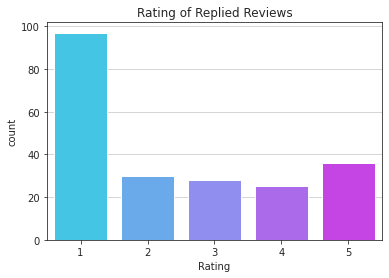

In [ ]:
reply = data[~data['Reply'].isna()]

sns.set_style("ticks",{'axes.grid' : True})
ax = sns.countplot(x = reply['Rating'], palette='cool')
ax.set_title('Rating of Replied Reviews')

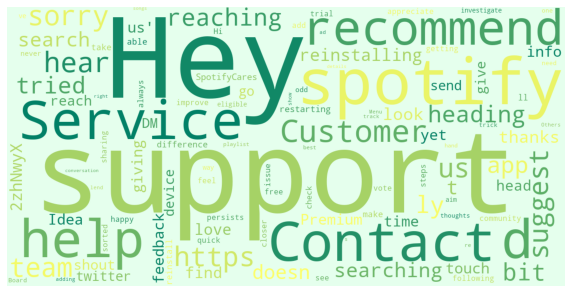

In [ ]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e5ffed', colormap='summer').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)

In [ ]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [ ]:
top_words(reply['Reply'])

Top 5 words that appear most frequently:

support	--> 204
Hey	--> 194
spotify	--> 166
Contact	--> 118
Service	--> 115


In [ ]:
data['Time_submitted'] = pd.to_datetime(data['Time_submitted'], errors ='coerce')

data['Date'] = data['Time_submitted'].apply(lambda x: x.date())

reviews_per_day = data.groupby(data['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)


In [ ]:
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

,Date,Total_review,Month
0,2022-01-01,46,1
1,2022-01-02,43,1
2,2022-01-03,66,1
3,2022-01-04,56,1
4,2022-01-05,64,1


Text(0.5, 1.0, 'Total Review per Day')

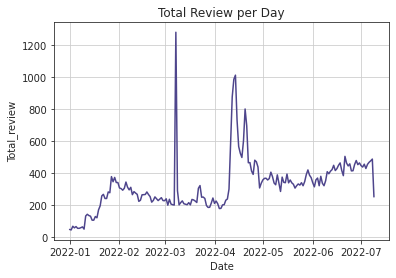

In [ ]:
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#4e458c')
ax.set_title('Total Review per Day')

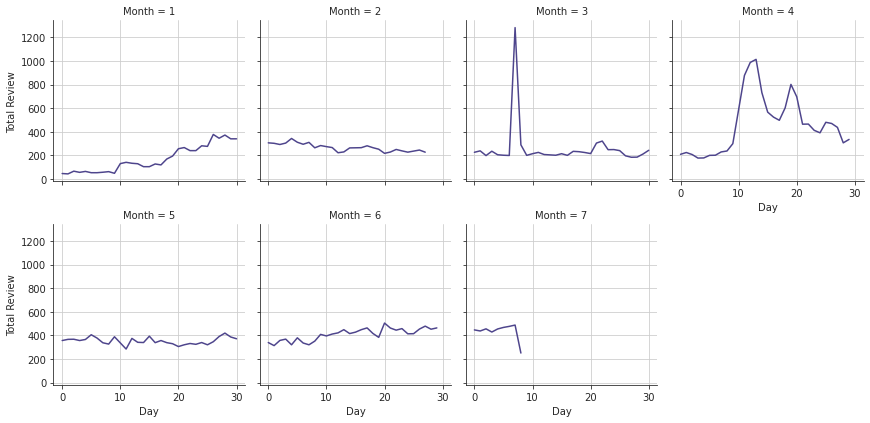

In [ ]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4e458c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

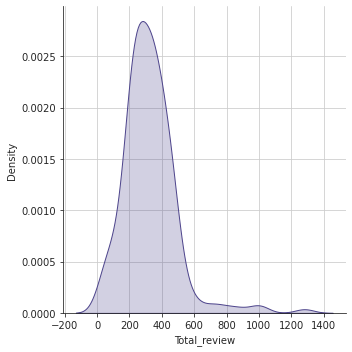

In [ ]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#4e458c')


We are going to transform the rating from integer to string and let's see the relationship between rating and length of words


In [ ]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

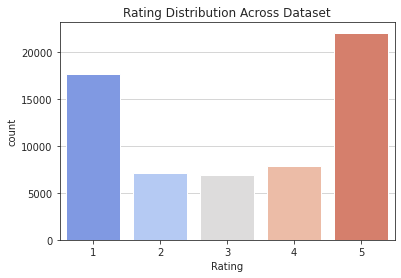

In [ ]:
ax = sns.countplot(data=data, x='Rating', palette='coolwarm')
ax.set_title('Rating Distribution Across Dataset')

Text(0.5, 1.0, 'Rating Distribution Across Dataset\nAfter Transformation')

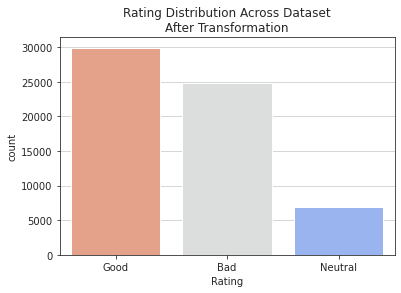

In [ ]:
data['Rating'] = data['Rating'].apply(rating)
ax = sns.countplot(data=data, x='Rating', palette='coolwarm_r')
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')

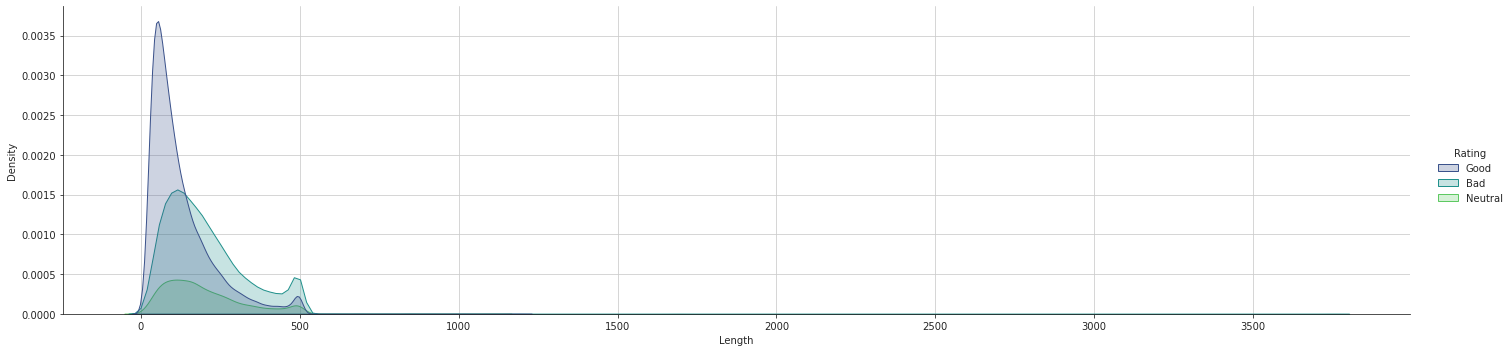

In [ ]:
data['Length'] = data['Review'].apply(len)
ax = sns.displot(data=data, x='Length', hue='Rating', kind='kde', fill=True, aspect=4, palette='viridis')

Text(0.5, 1.0, 'Distribution of review Length\nfor Each Rating')

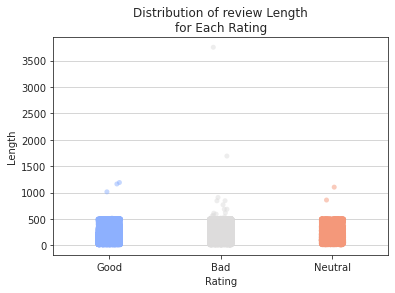

In [ ]:

ax = sns.stripplot(data=data, x='Rating', y='Length', alpha=0.5, palette='coolwarm')
ax.set_title('Distribution of review Length\nfor Each Rating')

Text(0.5, 1.0, 'Average of review Length\nfor Each Rating')

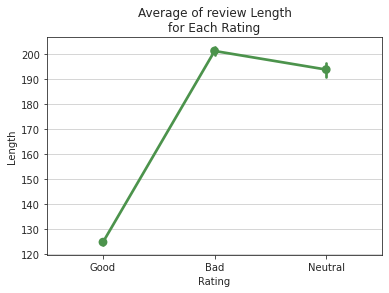

In [ ]:
ax = sns.pointplot(data=data, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')

In [ ]:
max_thumb = data['Total_thumbsup'].max()
print(data[data['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

The app is very good. I got to explore many new songs. However, I took out a star because of a few reasons. First:- It sometimes lags and won't show the music dialog box on your screen or in the app and for this I have to restart it. Second:- I cannot delete my history on phone. Third:- I cannot shuffle playlists or Albums. They have to play on the fixed sequence. Fourth:- I cannot see which song is going to play next if it's a radio and Fifth:- Sometimes the song stops and doesn't start radio


Text(8, -0.2, 'Mean: 7.65')

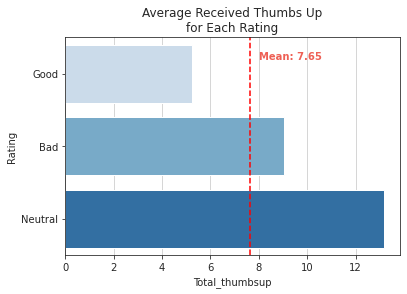

In [ ]:
mean_thumb = data['Total_thumbsup'].mean()

ax = sns.barplot(data=data, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette='Blues')
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')


Text(0.5, 1.0, 'Distribution of Received Thumbs Up\nfor Each Rating')

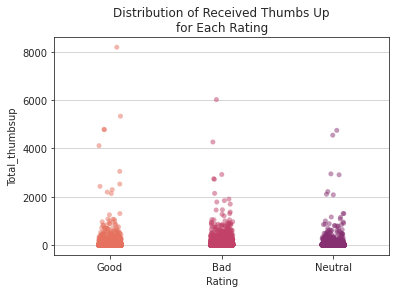

In [ ]:
ax = sns.stripplot(data=data, x='Rating', y='Total_thumbsup', palette='flare', alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')

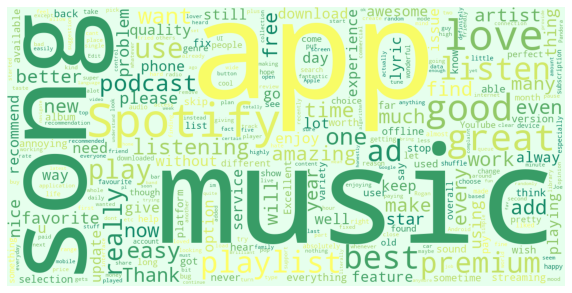

In [ ]:
# Most popular word for good review
good = data[data['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)

In [ ]:
top_words(good)

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


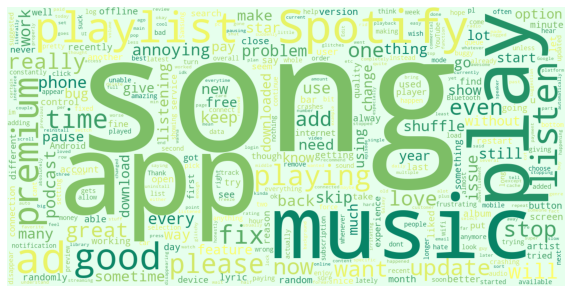

In [ ]:
# Most popular word for netral review
neutral = data[data['Rating'] == 'Neutral']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(neutral))

plt.axis('off')
plt.imshow(wc)

In [ ]:
top_words(neutral)

Top 5 words that appear most frequently:

song	--> 4993
app	--> 4125
music	--> 2322
play	--> 2032
Spotify	--> 1837


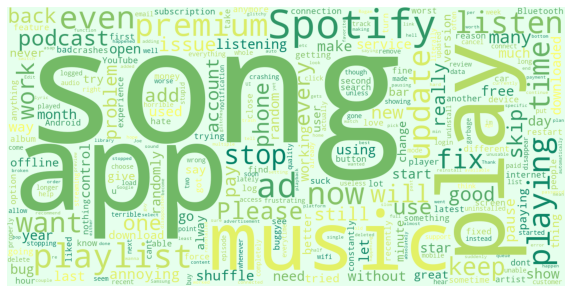

In [ ]:
# Most popular word for bad review
bad = data[data['Rating'] == 'Bad']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(bad))

plt.axis('off')
plt.imshow(wc)

In [ ]:
data.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Date,Length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",Good,2,NaN,2022-07-09,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,Good,1,NaN,2022-07-09,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",Good,0,NaN,2022-07-09,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,Bad,1,NaN,2022-07-09,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,Bad,1,NaN,2022-07-09,100


In [ ]:
df_final = data[['Review', 'Rating', 'Length']]

# Text preprocessing

In [ ]:
length = df_final['Length'].sum()

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print('Original:')
print(data['Review'][7])
print()

sentence = []
for word in data['Review'][7].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in data['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))


Original:
Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my searches or playlists.

Stemming:
still extrem slow when chang storag to extern sd card.. i'm convinc this is done on purpose, spotifi know of this issu and has done noth to solv it! over time i have chang sd cards, each be faster in read, write speeds(al samsung brand). and pleas add "don't like song" so it will never appear again in my search or playlists.

Lemmatization:
Still extremely slow when change storage to external sd card.. I'm convince this be do on purpose, spotify know of this issue and have do NOTHING to solve it! Over time I have change sd cards, each be faster in read, write speeds(all samsung brand). And please add "don't like song" 

In [ ]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [ ]:
data['Review'] = data['Review'].apply(cleaning)

In [ ]:
data['Length'] = data['Review'].apply(len)
new_length = data['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 10059745
Total word after cleaning: 6210516


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data['Rating'], test_size=0.2)

# Building Model

LSTM

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems

3 basic requirements of a recurrent neural network:
That the system be able to store information for an arbitrary duration.

That the system be resistant to noise (i.e. fluctuations of the inputs that are random or irrelevant to predicting a correct output).
That the system parameters be trainable (in reasonable time).

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 25469


In [ ]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           203752    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                3200      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 207,531
Trainable params: 207,531
Non-trainable params: 0
__________________________________________________

In [ ]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
1540/1540 [==============================] - 44s 24ms/step - loss: 0.9714 - accuracy: 0.5399 - val_loss: 0.7714 - val_accuracy: 0.7223
Epoch 2/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.7374 - accuracy: 0.7322 - val_loss: 0.6473 - val_accuracy: 0.7641
Epoch 3/25
1540/1540 [==============================] - 36s 24ms/step - loss: 0.6739 - accuracy: 0.7655 - val_loss: 0.6235 - val_accuracy: 0.7687
Epoch 4/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6446 - accuracy: 0.7787 - val_loss: 0.6054 - val_accuracy: 0.7756
Epoch 5/25
1540/1540 [==============================] - 38s 25ms/step - loss: 0.6271 - accuracy: 0.7871 - val_loss: 0.6012 - val_accuracy: 0.7772
Epoch 6/25
1540/1540 [==============================] - 36s 24ms/step - loss: 0.6122 - accuracy: 0.7919 - val_loss: 0.5941 - val_accuracy: 0.7807
Epoch 7/25
1540/1540 [==============================] - 36s 24ms/step - loss: 0.5953 - accuracy: 0.7971 - val_loss: 0.5914 -

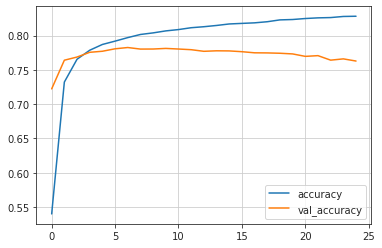

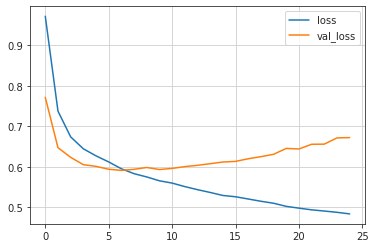

In [ ]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_lstm[['accuracy', 'val_accuracy']].plot()
metrics_lstm[['loss', 'val_loss']].plot()

Gated recurrent units are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. Another Interesting thing about GRU is that, unlike LSTM, it does not have a separate cell state (Ct). It only has a hidden state(Ht). Due to the simpler architecture, GRUs are faster to train.

In [ ]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           203752    
_________________________________________________________________
gru (GRU)                    (None, 8)                 432       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 204,211
Trainable params: 204,211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))


Epoch 1/25
1540/1540 [==============================] - 24s 15ms/step - loss: 1.0011 - accuracy: 0.4935 - val_loss: 0.8937 - val_accuracy: 0.5524
Epoch 2/25
1540/1540 [==============================] - 21s 13ms/step - loss: 0.8442 - accuracy: 0.6426 - val_loss: 0.7561 - val_accuracy: 0.7126
Epoch 3/25
1540/1540 [==============================] - 21s 14ms/step - loss: 0.7316 - accuracy: 0.7308 - val_loss: 0.6550 - val_accuracy: 0.7583
Epoch 4/25
1540/1540 [==============================] - 21s 14ms/step - loss: 0.6668 - accuracy: 0.7639 - val_loss: 0.6287 - val_accuracy: 0.7676
Epoch 5/25
1540/1540 [==============================] - 21s 14ms/step - loss: 0.6396 - accuracy: 0.7754 - val_loss: 0.6234 - val_accuracy: 0.7704
Epoch 6/25
1540/1540 [==============================] - 21s 14ms/step - loss: 0.6206 - accuracy: 0.7825 - val_loss: 0.6055 - val_accuracy: 0.7758
Epoch 7/25
1540/1540 [==============================] - 21s 14ms/step - loss: 0.6043 - accuracy: 0.7878 - val_loss: 0.6009 -

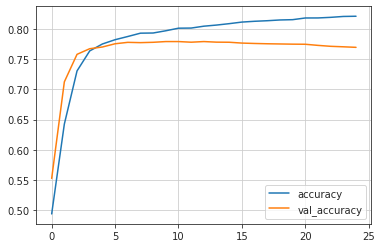

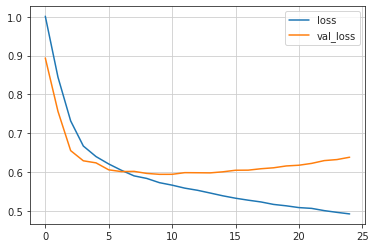

In [ ]:
metrics_gru = pd.DataFrame(model_gru.history.history)
metrics_gru[['accuracy', 'val_accuracy']].plot()
metrics_gru[['loss', 'val_loss']].plot()

In [ ]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def gru_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_gru.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [ ]:
text3 = "The overall experience is good, but the ads really annoying"

print('LSTM\t: ', lstm_prediction(text3))
print('GRU\t: ', gru_prediction(text3))


LSTM	:  Good
GRU	:  Good
